In [1]:
#loaded kaggle.jsonfile
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pallavisinha12","key":"9324304af385ab5b0da4fca5dbb5cc27"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#downloaded kaggle dataset
!kaggle datasets download -d trolukovich/food5k-image-dataset

food5k-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip food5k-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: evaluation/food/1.jpg   
  inflating: evaluation/food/10.jpg  
  inflating: evaluation/food/100.jpg  
  inflating: evaluation/food/101.jpg  
  inflating: evaluation/food/102.jpg  
  inflating: evaluation/food/103.jpg  
  inflating: evaluation/food/104.jpg  
  inflating: evaluation/food/105.jpg  
  inflating: evaluation/food/106.jpg  
  inflating: evaluation/food/107.jpg  
  inflating: evaluation/food/108.jpg  
  inflating: evaluation/food/109.jpg  
  inflating: evaluation/food/11.jpg  
  inflating: evaluation/food/110.jpg  
  inflating: evaluation/food/111.jpg  
  inflating: evaluation/food/112.jpg  
  inflating: evaluation/food/113.jpg  
  inflating: evaluation/food/114.jpg  
  inflating: evaluation/food/115.jpg  
  inflating: evaluation/food/116.jpg  
  inflating: evaluation/food/117.jpg  
  inflating: evaluation/food/118.jpg  
  inflating: evaluation/food/119.jpg  
  inflating: evaluation/food/12.jpg  
  inflating: eval

In [8]:
#checked for gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
#downloaded resnet pretrained model
model = torchvision.models.resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [7]:
#imported libraries(Run this cell first)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
#resizing image as per reqyirements of resnet
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
#used torchvision for loading dataset
trainset = torchvision.datasets.ImageFolder(root='/content/training', transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/evaluation', transform=transform)
evalset = torchvision.datasets.ImageFolder(root='/content/validation', transform=transform)

In [12]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)

In [13]:
#visualisation of image shape
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
1


In [14]:
#model
classes = ('food', 'nonfood')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
#already trained parameters need no training
for p in model.parameters():
  p.requires_grad = False

In [ ]:

print(model.fc)


Linear(in_features=2048, out_features=1000, bias=True)


In [16]:
#changed last sequential layer of model
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

In [17]:
#these weights need training
for param in model.parameters():
    
    
    if param.requires_grad:
        print(param.shape)

torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([2, 512])
torch.Size([2])


In [18]:
#shifted model to cuda
model = model.to(device)

In [19]:
import torch.optim as optim
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.NLLLoss()
opt = optim.Adam(model.parameters(), lr = 0.001)

In [20]:
import copy

In [21]:

def evaluation(dataloader):
    total, correct = 0, 0
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 0.00
Iteration: 0/1563, Loss: 0.00
Epoch: 0/2, Test acc: 98.30, Train acc: 98.90
Min loss 0.00
Min loss 0.00
Epoch: 1/2, Test acc: 98.50, Train acc: 99.07


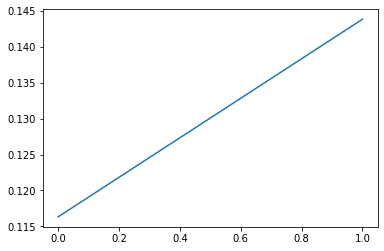

In [37]:

loss_epoch_arr = []
max_epochs = 2
min_loss = 1000
n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs,labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    model.train()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)
        
            if i % 100 == 0:
                print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
            del inputs, labels, outputs
            torch.cuda.empty_cache()
  loss_epoch_arr.append(loss.item())
  model.eval()
        
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()



In [38]:
print(evaluation(evalloader))

98.3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


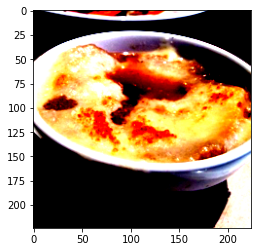

food
food


In [39]:
dataiter = iter(testloader)
images, labels = dataiter.next()
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(images[:1]))
#print(labels[0])
print(' '.join(classes[labels[j]] for j in range(1)))
images = images.to(device)
outputs = model(images)
max_values, pred_class = torch.max(outputs.data, 1)
#print(pred_class)
print(' '.join(classes[pred_class[j]] for j in range(1)))

    


In [34]:
model.load_state_dict(best_model)#print evaluation of just upto the checkpoint of model but it 
print(evaluation(trainloader), evaluation(testloader))

98.3 97.5


In [24]:
!pip install Pillow

In [25]:
from PIL import Image

In [26]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image
    

In [31]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    image = image.to(device)
    output = model(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [28]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model is  99.9417245388031 % certain that the image is  food


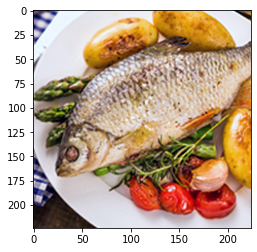

In [36]:
# Process Image
#image = process_image("/content/img.jpg")
image = process_image("/content/fish-food-dish1.jpg")
# Give image to model to predict output
top_prob, top_class = predict(image, model)
# Show the image
show_image(image)
if top_class == 0:
  c = "food"
else:
  c = "non_food"
# Print the results
print("The model is ", top_prob*100, "% certain that the image is ", c  )